In [8]:
from six.moves import cPickle
import os
import utils as ut
import matplotlib.pyplot as plt
import numpy as np
import importlib
from tqdm import tqdm
import mlpBonus as mlp

Using TensorFlow backend.


In [9]:
K, d, n = 10, 3072, 10000
np.random.seed(42)
mu, sigma = 0, 0.01 
batch_start, batch_end= 0, 20

# Data Preprocessing

In [10]:
def normalize_data(X, mean, std):
    X -= np.outer(mean_X, np.ones(X.shape[1]))
    X /= np.outer(std_X, np.ones(X.shape[1]))
    return X
    
importlib.reload(ut)
X_train, y_train, Y_train = ut.loadData('data_batch_1', clipping=True)
X_val, y_val, Y_val = ut.loadData('data_batch_2', clipping=True)
X_test, y_test, Y_test = ut.loadData('test_batch', clipping=True)

## normalize with mean and std of train set 
mean_X = np.mean(X_train, axis=1)
std_X = np.std(X_train, axis=1)

X_train = normalize_data(X_train, mean_X, std_X)
X_val = normalize_data(X_val, mean_X, std_X)
X_test = normalize_data(X_test, mean_X, std_X)
data = {"X_train": X_train, "y_train": y_train, "Y_train": Y_train, "X_val":X_val, "y_val": y_val, "Y_val": Y_val}

In [11]:
importlib.reload(ut)
X_train_whole, y_train_whole, Y_train_whole = ut.loadData('data_batch_1', clipping=True)

for i in range(2,6):
    X, y, Y = ut.loadData('data_batch_'+str(i), clipping=True)
    X_train_whole = np.concatenate((X, X_train_whole), axis=1)
    y_train_whole = np.concatenate((y, y_train_whole))
    Y_train_whole = np.concatenate((Y, Y_train_whole), axis=1)

n_val = 5000

X_val_small, y_val_small, Y_val_small = X_train_whole[:,-n_val:], y_train_whole[-n_val:], Y_train_whole[:,-n_val:]
X_train_whole, y_train_whole, Y_train_whole = X_train_whole[:,:-n_val], y_train_whole[:-n_val], Y_train_whole[:,:-n_val]

## normalize with mean and std of train set 
mean = np.mean(X_train_whole, axis=1)
std = np.std(X_train_whole, axis=1)

X_train_whole = normalize_data(X_train_whole, mean, std)
X_val_small = normalize_data(X_val_small, mean, std)

data_whole = {"X_train": X_train_whole, "y_train": y_train_whole, "Y_train": Y_train_whole, "X_val":X_val_small, "y_val": y_val_small, "Y_val": Y_val_small}

In [12]:
importlib.reload(ut)
X_train_whole, y_train_whole, Y_train_whole = ut.loadData('data_batch_1', clipping=True)

for i in range(2,6):
    X, y, Y = ut.loadData('data_batch_'+str(i), clipping=True)
    X_train_whole = np.concatenate((X, X_train_whole), axis=1)
    y_train_whole = np.concatenate((y, y_train_whole))
    Y_train_whole = np.concatenate((Y, Y_train_whole), axis=1)

n_val = 1000

X_val_small, y_val_small, Y_val_small = X_train_whole[:,-n_val:], y_train_whole[-n_val:], Y_train_whole[:,-n_val:]
X_train_whole, y_train_whole, Y_train_whole = X_train_whole[:,:-n_val], y_train_whole[:-n_val], Y_train_whole[:,:-n_val]

## normalize with mean and std of train set 
mean = np.mean(X_train_whole, axis=1)
std = np.std(X_train_whole, axis=1)

X_train_whole = normalize_data(X_train_whole, mean, std)
X_val_small = normalize_data(X_val_small, mean, std)

data_best = {"X_train": X_train_whole, "y_train": y_train_whole, "Y_train": Y_train_whole, "X_val":X_val_small, "y_val": y_val_small, "Y_val": Y_val_small}

# Ensemble Learning + Cyclical Learning

In [17]:
importlib.reload(mlp)
ensemble = mlp.MLP(lamda=0.0023)
GDparams = {"n_batch":100, "n_cycles":4, "eta_min":1e-5, "eta_max":1e-1, "ns":980, "freq":10, "exp":"ensemble_learning"}
ensemble.cyclic_learning(data_best, GDparams, verbose=True, backup=True)

  0%|          | 0/16 [00:00<?, ?it/s]Update Step 0: train_acc=0.1 | val_acc=0.109 | train_loss=2.533464399954116 | val_loss=2.4985049242731345 | train_cost=2.670202133759491 | val_cost=2.6352426580785093
Update Step 196: train_acc=0.36689795918367346 | val_acc=0.351 | train_loss=1.7883139314980012 | val_loss=1.7930785327543677 | train_cost=1.9235225395885227 | val_cost=1.9282871408448892
Update Step 392: train_acc=0.4020612244897959 | val_acc=0.389 | train_loss=1.6877247998769918 | val_loss=1.7212398833217075 | train_cost=1.8184351128291922 | val_cost=1.8519501962739082
  6%|▋         | 1/16 [00:39<09:48, 39.22s/it]Update Step 588: train_acc=0.4123469387755102 | val_acc=0.394 | train_loss=1.6593423813931163 | val_loss=1.6861190158314348 | train_cost=1.783514504161411 | val_cost=1.8102911385997296
Update Step 784: train_acc=0.4516734693877551 | val_acc=0.437 | train_loss=1.561658545546999 | val_loss=1.5926046939191922 | train_cost=1.6784675319206714 | val_cost=1.7094136802928648
 12%|█

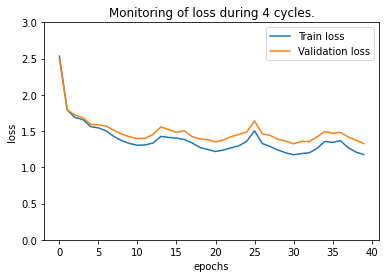

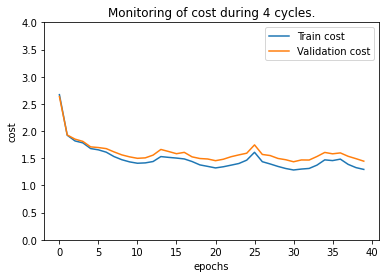

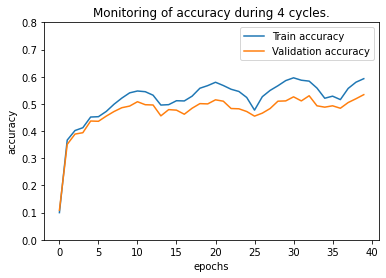

In [22]:
ensemble.plot_metric(GDparams, metric="loss")
ensemble.plot_metric(GDparams, metric="cost")
ensemble.plot_metric(GDparams, metric="accuracy")

In [24]:
ensemble.compute_accuracy(X_test, y_test)

0.5251

In [26]:
importlib.reload(mlp)
GDparams = {"n_batch":100, "n_cycles":4, "eta_min":1e-5, "eta_max":1e-1, "ns":980, "freq":10, "exp":"ensemble_learning"}
classes, acc = mlp.MLP.majority_voting(X_test, y_test, GDparams, n_cycle=4, lamda=0.0023)
acc

0.5231

# Estimate Boundaries

In [34]:
importlib.reload(mlp)
net = mlp.MLP()
GDparams = {"n_batch":100, "n_epochs":8, "eta_min":1e-10, "eta_max":3e-2, "exp":"ensemble_learning"}
etas, accuracies = net.lr_range_test(data, GDparams, verbose=False)

 62%|██████▎   | 5/8 [23:25<13:59, 279.83s/it]d:\insa\5if\KTH\P4\DL\Assignements\dl_labs\lab2\mlpBonus.py:55: RuntimeWarning: divide by zero encountered in log
  loss = np.log(np.sum(np.multiply(Y, P), axis=0))
d:\insa\5if\KTH\P4\DL\Assignements\dl_labs\lab2\mlpBonus.py:55: RuntimeWarning: divide by zero encountered in log
  loss = np.log(np.sum(np.multiply(Y, P), axis=0))
d:\insa\5if\KTH\P4\DL\Assignements\dl_labs\lab2\mlpBonus.py:55: RuntimeWarning: divide by zero encountered in log
  loss = np.log(np.sum(np.multiply(Y, P), axis=0))
d:\insa\5if\KTH\P4\DL\Assignements\dl_labs\lab2\mlpBonus.py:12: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x), axis=0)
d:\insa\5if\KTH\P4\DL\Assignements\dl_labs\lab2\mlpBonus.py:12: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x) / np.sum(np.exp(x), axis=0)
d:\insa\5if\KTH\P4\DL\Assignements\dl_labs\lab2\mlpBonus.py:55: RuntimeWarning: divide by zero encountered in log
  loss = np.log(np.sum

No handles with labels found to put in legend.


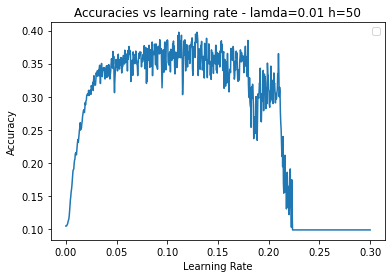

In [35]:
mlp.MLP.plot_accuracies(etas, accuracies, lamda=0.01, h=50)

No handles with labels found to put in legend.


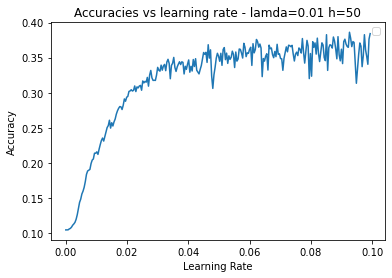

In [42]:
mlp.MLP.plot_accuracies(etas[:266], accuracies[:266], lamda=0.01, h=50)


In [43]:
np.save('History/etas_1.npy', etas)
np.save('History/accuracies_1.npy', accuracies)